============== Expand American ==============


S :  2022705
Cost of expansion :  -467286
T :  5
V :  0.2304
r :  0.05
T_interval :  1
Expansion factor :  0.5


<forward calculation>
0year: 2022705
1year: 2546795, 1606464
2year: 3206679, 2022705, 1275879
3year: 4037541, 2546795, 1606464, 1013324
4year: 5083682, 3206679, 2022705, 1275879, 804798
5year: 6400882, 4037541, 2546795, 1606464, 1013324, 639183
**expand option apply for last list**
[6400882, 4037541, 2546795, 1606464, 1013324, 786878]
[[2022705], [2546795, 1606464], [3206679, 2022705, 1275879], [4037541, 2546795, 1606464, 1013324], [5083682, 3206679, 2022705, 1275879, 804798], [6400882, 4037541, 2546795, 1606464, 1013324, 786878]]
<backward calculation>
nyear: 6400882, 4037541, 2546795, 1606464, 1013324, 786878
4year: 5083682, 3206679, 2022705, 1275879, 869685
3year: 4037541, 2546795, 1606464, 1040917
2year: 3206679, 2022705, 1287613
1year: 2546795, 1611454
0year: 2024827
============== <expansion node check> ==============
nyear: 6400882, 4037541, 2546795, 1606464, 1013324, 786878
4year: 5083682, 3206679, 2022705, 1275879, 869685
3year: 4037541, 2546795, 1606464, 1040917
2year: 320667

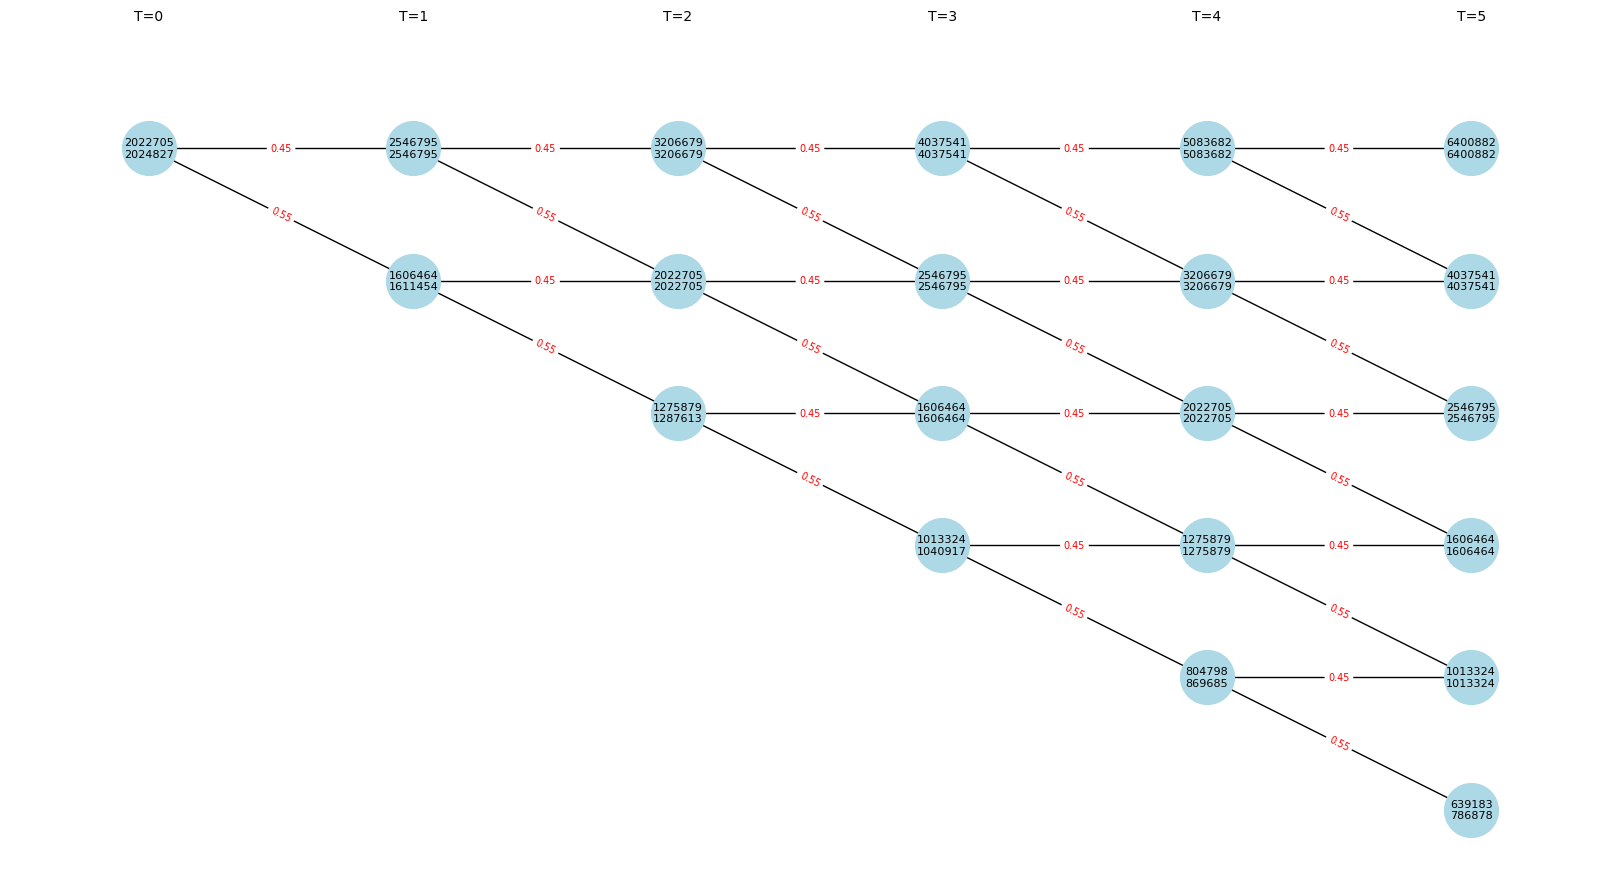

In [2]:
#expand
import math
import matplotlib.pyplot as plt
import networkx as nx

print("="*14,'Expand American','='*14)


S = float(input('S : '))
X = float(input('Cost of expansion : '))
T = int(input('T : '))
V = float(input('V : '))
r = float(input('r : '))
T_interval = int(input('T_interval : '))
E = float(input('Expansion factor : '))
print('='*50)

u = math.exp(V * (T_interval**0.5)) 
d = 1 / u 
p = (math.exp(r * T_interval) - d) / (u - d) 

T = int(T/T_interval)

results = []
original_results = []
print('<forward calculation>')

for i in range(T + 1):  
    year_result = []  

    if i == 0:
        year_result.append(round(S)) 

    else:
        for j in range(i + 1): 
            value = S * (u ** (i - j)) * (d ** j) 
            year_result.append(round(value)) 
        
    results.append(year_result)
    original_results.append(year_result)
    print(f"{i}year: {', '.join(map(str, year_result))}")


print('='*50)
fix_result = []
for i in range(len(results[T])):
    if results[T][i]*E-X > results[T][i]:
        fix_result.append(results[T][i]*E-X)
    else:
        fix_result.append(results[T][i])
fix_result = [round(x) for x in fix_result]


print('**expand option apply for last list**')
print(fix_result)
results[T] = fix_result
print(results)
backward_results = [None] * (T + 1) 
print('='*50)
print('<backward calculation>')
backward_results[0] = results[T]
print(f"nyear: {', '.join(map(str, results[T]))}")

expand_value = []
for i in range(T - 1, -1, -1): 
    next_year_result = []

    for j in range(len(results[i])):

        value = ((p * backward_results[T - i - 1][j]) +
                 (1 - p) * backward_results[T - i - 1][min(j + 1, len(backward_results[T - i - 1]) - 1)]) \
                 * math.exp(-r * T_interval)
        value = round(value)  

        condition_value = (results[i][j] * E) - X
        if value < condition_value:
            value = round(condition_value)
            expand_value.append(round(condition_value))
            
        next_year_result.append(round(value))

    backward_results[T - i] = next_year_result

    print(f"{i}year: {', '.join(map(str, next_year_result))}")

#-----------------------------------------------------------------------------------------------------------------
#Color check
print("="*14,'<expansion node check>',"="*14)
backward_results.reverse()
output = []
for orig, res in zip(original_results[-1], results[-1]):
    if res > orig:
        output.append(f"\033[94m{res}\033[0m")  # 더 큰 값은 파란색으로 표시
    else:
        output.append(str(res))  # 같은 값이거나 작은 값은 기본 색으로 표시

# 첫 번째 비교 결과 출력
output_str = "nyear: " + ', '.join(output)
print(output_str)

# 두 번째 비교: backward_results의 마지막 리스트를 제외하고 거꾸로 순회하여 값 비교
output = []
for i, row in enumerate(backward_results[:-1][::-1]):  # 리스트를 거꾸로 순회
    row_output = []
    for value in row:
        if value in expand_value:
            row_output.append(f"\033[94m{int(value)}\033[0m")  # expand_value에 있는 값은 파란색으로 표시
        else:
            row_output.append(str(int(value)))  # 나머지 값은 기본 색으로 표시
    output.append(f"{len(backward_results) - i - 2}year: " + ', '.join(row_output))

# 두 번째 비교 결과 출력
output_str = '\n'.join(output)
print(output_str)
print('\n')
#--------------------------------------------------------------------------------------------------------------------
#graph drawing
p1 = p
def plot_binomial_lattice(original_results, backward_results, p=round(p1, 2), save_path="expand_american.png"):
    G = nx.Graph()
    pos = {}
    steps = len(original_results) - 1 
    
    for i in range(steps + 1):
        for j in range(i + 1):
            forward_price = original_results[i][j]
            backward_value = backward_results[i][j]
            G.add_node((i, j), forward_price=forward_price, backward_value=backward_value)
            pos[(i, j)] = (i, -j) 
            
            if i < steps:
                G.add_edge((i, j), (i + 1, j), weight=round(1-p, 2))
                G.add_edge((i, j), (i + 1, j + 1), weight=round(p, 2))

    plt.figure(figsize=(16, 8))
    nx.draw(G, pos, with_labels=False, node_size=1500, node_color="lightblue", node_shape="o", font_size=8)
    
    for node, attr in G.nodes(data=True):
        x, y = pos[node]
        plt.text(x, y, f"{int(attr['forward_price'])}\n{int(attr['backward_value'])}", 
                 ha='center', va='center', color="black", fontsize=8)

    edge_labels = {(i, j): f"{G[i][j]['weight']:.2f}" for i, j in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=7)
    
    for i in range(steps + 1):
        plt.text(i, 1, f"T={i}", ha='center', va='center', fontsize=10, color="black")

    plt.xlabel("Steps (i)")
    plt.ylabel("Nodes (j)")

    plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    plt.show()

plot_binomial_lattice(original_results, backward_results) #file name = expand_american.png

In [60]:
print(expand_value)

[]
